In [1]:
import os
import sys 
import glob 
import h5py

import numpy as np 
import matplotlib.pyplot as plt 

import keras as K 

sys.path.append('../py_modules/') 
from utils import read_h5py_file, cm_to_cvae_trim

Using TensorFlow backend.


In [2]:
cm_files = sorted(glob.glob('../../*_traj/contacts/contacts-*.h5')) 

In [3]:
def read_h5py_len(h5_file):
    with h5py.File(h5_file, 'r', libver='latest', swmr=True) as cm_h5:
        if 'contact_maps' in cm_h5.keys():
            return cm_h5[u'contact_maps'].shape[1]
        elif 'contacts' in cm_h5.keys():
            return cm_h5['contacts'].shape[1]
        else:
            return 0
        
len_traj = [read_h5py_len(cm_file) for cm_file in cm_files]
num_frames = sum(len_traj)

print(f"Processing {num_frames} frames...")

Processing 2972486 frames...


The residue list is as follows:

`42-58
72-74
79-85
92-100
104-114
117-128`

In [4]:
AA_list = np.hstack([np.arange(41, 58), np.arange(71,74), np.arange(78,85), 
          np.arange(91,100), np.arange(103,114), np.arange(116,128)])

In [5]:
def cm_generator(cm_files, batch_size, resnum, shuffle=True): 
#     samples_per_epoch = len(cm_files) 
    number_of_files = len(cm_files)  
    counter = 0 
    if shuffle: 
        np.random.shuffle(cm_files) 
    cm_data_lists = []
    
    while 1: 
        # assuming batch size is way smaller than number of cm in each file 
        # therefore, it's sufficient to load only one extra while current is 
        # exhausted 
        if counter >= len(cm_files) and len(cm_data_lists) < batch_size: 
            # Reset counter to next epoch
            # cvae_input, cm_data_lists = cm_data_lists, [] 
            counter = 0 
        else: 
            if len(cm_data_lists) < batch_size:              
                new_cm = cm_to_cvae_trim([read_h5py_file(cm_files[counter])], AA_list) 
#                 print(new_cm.shape) 
                counter += 1 
                if cm_data_lists == []: 
                    cm_data_lists = new_cm
                else: 
                    cm_data_lists = np.array(np.vstack([cm_data_lists, new_cm])) 
            cvae_input, cm_data_lists = cm_data_lists[:batch_size], cm_data_lists[batch_size:]
        
        yield cvae_input, cvae_input 
        

In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(0) 

In [7]:
batch_size = 128 
np.random.shuffle(cm_files) 

train_val_split = int(0.8 * len(cm_files)) 
cm_data_train, cm_data_val = cm_files[:train_val_split], cm_files[train_val_split:]
train_generator = cm_generator(cm_data_train, batch_size, AA_list) 
val_generator = cm_generator(cm_data_val, batch_size, AA_list) 


len_train = sum([read_h5py_len(cm_file) for cm_file in cm_data_train])
len_val = sum([read_h5py_len(cm_file) for cm_file in cm_data_val]) 
print(f"Training on {len_train} frames and valiadating on {len_val}")

steps_per_epoch = len_train // batch_size
validation_steps = len_val // batch_size 

Training on 2370779 frames and valiadating on 601707


In [8]:
from cvae.CVAE import CVAE 
cvae = CVAE((60, 60, 1), 3)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 60, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 30, 30, 64)   36928       conv2d_2[0][0]                   
_____________________________________

In [13]:
cvae.model.fit_generator(generator=train_generator,
                         validation_data=val_generator, 
                         steps_per_epoch=steps_per_epoch, 
                         validation_steps=validation_steps, 
                         epochs=50,
                        )

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


/home/shozeb/miniconda3/envs/py3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


    4/18521 [..............................] - ETA: 7:52:29 - loss: 3826.2350 

/home/shozeb/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


  210/18521 [..............................] - ETA: 2:15:22 - loss: 299.7400

KeyboardInterrupt: 

In [ ]:
def read_h5py_len(h5_file):
    with h5py.File(h5_file, 'r', libver='latest', swmr=True) as cm_h5:
        if 'contact_maps' in cm_h5.keys():
            return cm_h5[u'contact_maps'].shape[1]
        elif 'contacts' in cm_h5.keys():
            return cm_h5['contacts'].shape[1]
        else:
            return 0
        
len_traj = [read_h5py_len(cm_file) for cm_file in cm_files]


In [10]:
def read_h5py_shape(h5_file):
    with h5py.File(h5_file, 'r', libver='latest', swmr=True) as cm_h5:
        if 'contact_maps' in cm_h5.keys():
            return cm_h5[u'contact_maps'].shape
        elif 'contacts' in cm_h5.keys():
            return cm_h5['contacts'].shape
        else:
            return 0
        
shape_traj = [read_h5py_shape(cm_file) for cm_file in cm_files]

# Corrupted h5 tracker 

Found frame 1232, 1635, 
add _ in front of filenames contact-1.h5. 
```python 
cm_files[1635]

with h5py.File(cm_files[1635], 'r') as h5: 
    print(h5.keys)

for i in range(1636, len(shape_traj)): 
    print(shape_traj[i], i)
    print(shape_traj[i], np.array(shape_traj[i])[0])
```

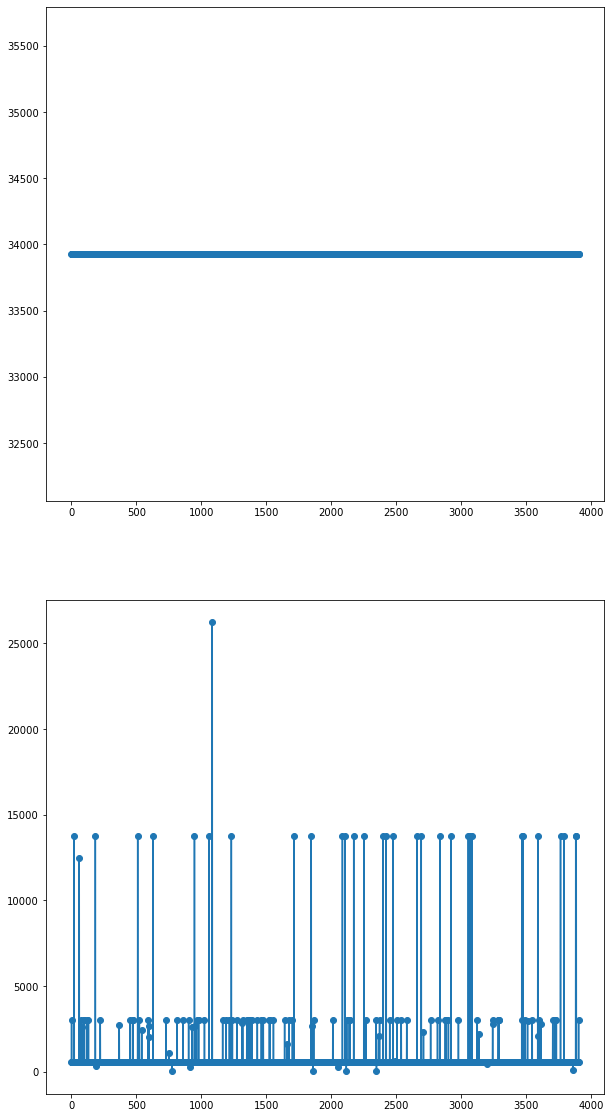

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20)) 
for i, ax in enumerate(axes):     
    ax.plot(np.array(shape_traj)[:,i], marker='o')